In [3]:
import numpy as np
import scipy
import pandas as pd
import pybedtools as pb

# figs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150
import seaborn as sns


#import h5py
#import allel

# my libs
import EnrichRLib as erl
import RNA_expression_processing as rn
import Enh_Mut_Manip as emm

# warnings
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter("ignore", ResourceWarning)

In [4]:
### == Math functions == 
def log2p1(x):
    return np.log2(x + 1)

In [5]:
# Project settings
from os.path import join 
WORKDIR = '/home/sergio/Res_CIML/TLX3_project'
SCRIPTS = join(WORKDIR,'scripts')
DATADIR = join(WORKDIR,'data')
WGS = join(DATADIR,'tracks/WGS-WES/Germline')
RP = join(DATADIR,'tracks/MARGE/relativeRP/bam_input')

# Data loading

### Genome Wide mutations in TLX3

In [6]:
## == Genome vcf
tlx_gn = pb.BedTool(join(WGS,'TLX3_WGS.vcf.gz'))

### RNA-expression table TLX3-vs-RAG

In [7]:
## == Expression table TLX3 vs RAG
tbl = pd.read_table(join(DATADIR,'tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

# -- Pheno --
#A,B = 'TLX3','RAG'
#classes = [A]*3+[B]*3


cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
expr = tbn.set_index(keys=tbn.columns[0])
#expr.index = expr.index.str.upper()

### Enhancers from chromatin states

In [8]:
## == Enhancers 
enh = pb.BedTool(join(DATADIR,'tracks/Enhancers_RAG_ChromHMM.bed'))
enh_df = enh.to_dataframe()

# Enh to genes table
enh2gn = pd.read_table(join(DATADIR,'tracks/Enhancers_RAG_enh2genes.txt'), 
                        header=1, 
                        names=['enhancers','gene_name'])
# Gene to enh table
gn2enh = pd.read_table(join(DATADIR,'tracks/Enhancers_RAG_genes2enh.txt'), 
                        header=1, 
                        names=['gene_name','enhancers'])


### Annotations: genes, tss, T-all oncogenes etc.

In [9]:
# Load T-ALL ocnogenes
tall = erl.read_gmt(join(DATADIR,'gene_lists/Cancermine/T-ALL.gmt')) 
df_mut = pd.read_csv(join(DATADIR,'gene_lists/COSMIC/Genes_mutation_HUMAN_Acute-lymphoblastic-leukaemia.csv'))

df_mut['Gname'] = df_mut['Gene name'].apply(lambda x: x.split('_')[0])

tall_onc = tall['T-ALL all']
tall_mut = list(df_mut['Gname'].unique())

# Load genes body regions
genes = pb.BedTool(join(DATADIR,'tracks/annot_tracks/references/mm9/mm9.refGene.bed'))


# Story ONE: Active in RAG only enhancers and inactive genes 

![title](im/Story1RAG.png)

## Active enhacers in RAG not in TLX3 based on H4K27ac potential

In [10]:
pad = 3e3 # 3k padding 

#tlx_27ac = join(DATADIR,'tracks/ChiP-seq_tracks/mm9_bigWig/TAP_H3K27ac_mm9.bw')
#rag_27ac = join(DATADIR,'tracks/ChiP-seq_tracks/mm9_bigWig/RAG_H3K27ac_mm9.bw')


#enh_27ac_tlx = emm.bigWig2bed_pot(tlx_27ac,enh,'mm9',pad=pad)

tlx_27ac = pd.read_csv(join(DATADIR,'tracks/Enhancers_RAG_ChromHMM_TLX3_H3K27ac.csv'), index_col=0)
rag_27ac = pd.read_csv(join(DATADIR,'tracks/Enhancers_RAG_ChromHMM_RAG_H3K27ac.csv'), index_col=0)

tlx_27ac.rename(columns={'RP':'RP_tlx'}, inplace=True)

rag_27ac.rename(columns={'RP':'RP_rag'}, inplace=True)

tlx_rag_27ac = pd.concat([tlx_27ac,rag_27ac.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

## Scatter plot of enhacer's activity TLX3-vs-RAG: color logFoldChange

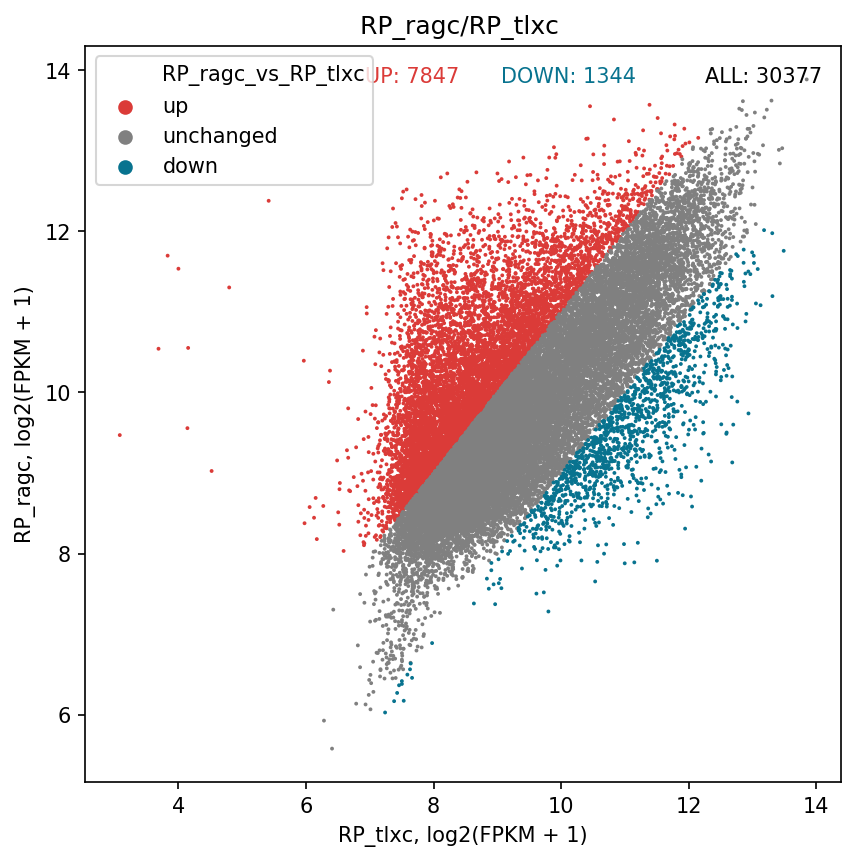

In [11]:
## Scatter of 27ac potential on enhancers

Ap,Bp = 'RP_rag','RP_tlx'
cols = ['name', Ap, Bp]

tlx_rag_27ac_s = tlx_rag_27ac[cols]

tlx_rag_27ac_s = tlx_rag_27ac_s.set_index(keys=tlx_rag_27ac_s.columns[0])

tlx_rag_27ac_s = tlx_rag_27ac_s.apply(pd.to_numeric)

Ac= Ap+'c'
Bc= Bp+'c'

classes=[Ac,Bc]
#df_mean= tlx_rag_27ac_s.groupby(by=classes, axis=1).mean()

up,dn,_=rn.scatter_n(tlx_rag_27ac_s, Ac, Bc,classes=classes)

In [12]:
## UP regulated by H3K27ac enhancers
tlx_rag_27ac_FC=up#df[0]


### genes associate with top UP enhancers
tlx_vs_rag_top = list(tlx_rag_27ac_FC.index)
tlx_vs_rag_topGenes = emm.gene_enh(tlx_vs_rag_top,enh2gn)


## UP/DOWN genes regulated by activated in RAG enhacers  

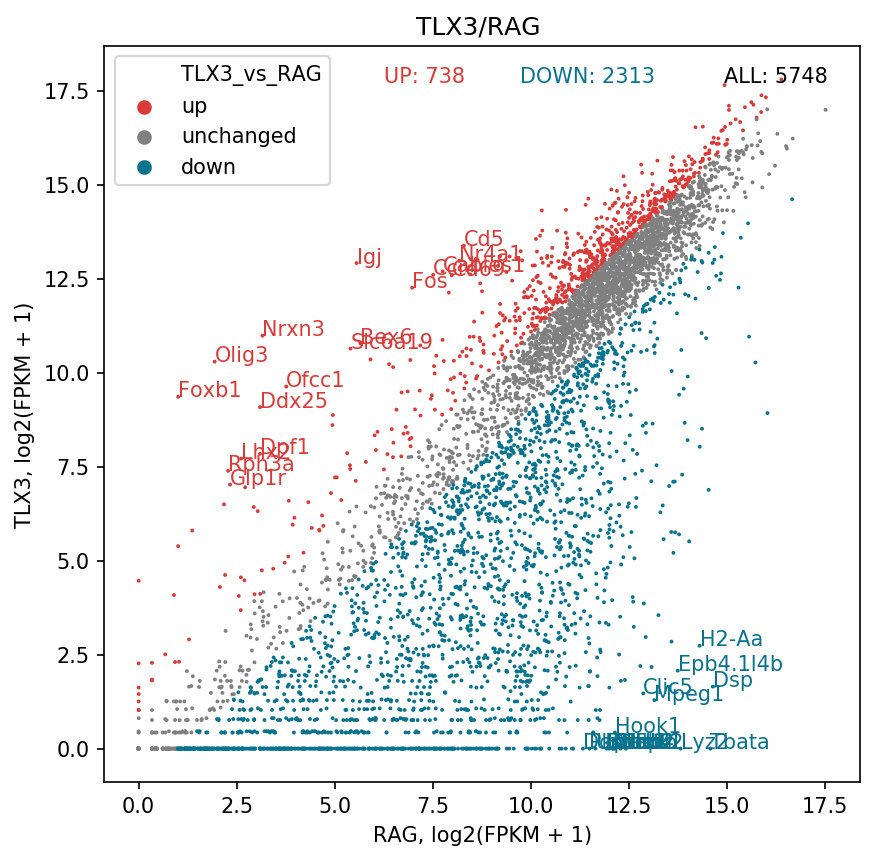

In [13]:
# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

upg,dng,_=rn.scatter_n(expr[expr.index.isin(tlx_vs_rag_topGenes)], A, B,classes=classes, n_top=18)

In [14]:
## enhancers from DOWN genes
dn_genes = list(dng.index)
dn_gene_enh =  emm.enh_gene(dn_genes,gn2enh)

In [15]:
print('Up regulated enhancers = ',len(tlx_vs_rag_top))
print('Enhancers of down-regulated genes  = ',len(dn_gene_enh))

Up regulated enhancers =  7847
Enhancers of down-regulated genes  =  11325


In [16]:
# Up enhancers with down genes
dn_enh_up_genes = list(set(tlx_vs_rag_top) & set(dn_gene_enh))
print('Up enhancers of down-regulated genes  = ',len(dn_enh_up_genes))

Up enhancers of down-regulated genes  =  4968


In [17]:
# Load TLX3 peaks
tlx_pk = pb.BedTool(join(DATADIR,'tracks/TLX3_TLX3_peaks.bed'))
sl = 100
tlx_pk = tlx_pk.slop(b=sl, genome='mm9')

enh_up_dn= enh_df[enh_df['name'].isin(dn_enh_up_genes)]
enh_up_dn_bd = pb.BedTool.from_dataframe(enh_up_dn)

enh_up_dn_tlx = (enh_up_dn_bd + tlx_pk).to_dataframe()

In [18]:
# Finally
# associated genes
enh_up_dn_tlx_genes = emm.gene_enh(list(enh_up_dn_tlx['name']),enh2gn)

print('Genes for UP regulated (H3K27ac) enhancers with TLX3 peaks  with DOWN regulated genes = ',len(enh_up_dn_tlx_genes))
print('UP regulated (H3K27ac) enhancers with TLX3 peaks  with DOWN regulated genes = ',len(enh_up_dn_tlx))

Genes for UP regulated (H3K27ac) enhancers with TLX3 peaks  with DOWN regulated genes =  175
UP regulated (H3K27ac) enhancers with TLX3 peaks  with DOWN regulated genes =  98


## DOWN regulated final genes

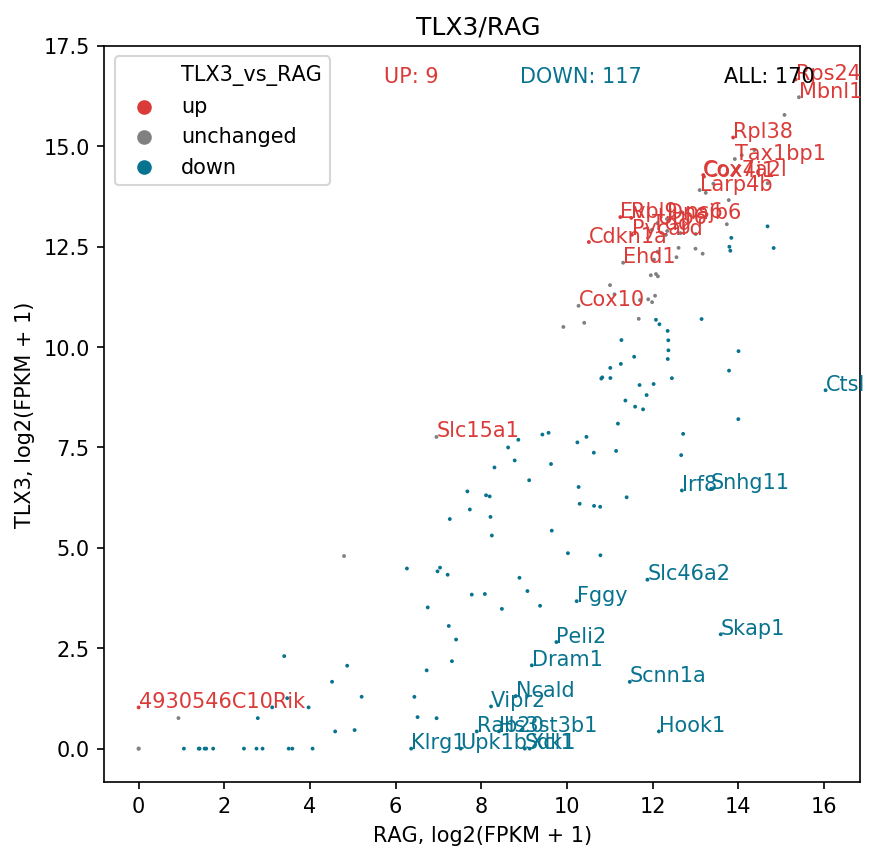

In [19]:
## Expression of last genes

# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

upgg,dngg,_=rn.scatter_n(expr[expr.index.isin(enh_up_dn_tlx_genes)], A, B,classes=classes, n_top=18)

## Enrichment of final 117 genes

In [20]:
fin_dn_genes = list(dngg.index)

## Enrichment analysis
# List of gene sets 
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016',
       'Cancer_Cell_Line_Encyclopedia',
       'NCI-60_Cancer_Cell_Lines',
       ]

FIN_dn_genes = [x.upper() for x in fin_dn_genes]

enr = erl.enrich_gs(FIN_dn_genes,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 923
GO_Cellular_Component_2018 75
GO_Molecular_Function_2018 190
KEGG_2016 115
Reactome_2016 216
Cancer_Cell_Line_Encyclopedia 630
NCI-60_Cancer_Cell_Lines 75


In [50]:
def cluser_enrich(enr,gl,pval=0.05, top_clusters=20, spring=150):
    #2= Filter terms by p-Val
    enr = enr[enr['p-Val']<pval]

    #3= Make claster by kappa coeff
    enr = erl.cluster(set(gl), enr, deep=2)

    #3-1= Filter top clusters
    enr = enr[enr['cluster']<top_clusters]

    #4= Make clustered geneset 
    gs_clust,nt_cl = erl.cluster_genset(enr)

    #5= Enrich clustered geneset
    enr_clust = erl.enrich(gl,gs_clust)
    
    # deduplicate index -- TODO!!! in package
    nt_cl = nt_cl.loc[~nt_cl.index.duplicated(keep='first')]

    #6= Add cluster to table
    enr_clust = pd.concat([enr_clust,nt_cl.loc[enr_clust.index]['cluster']],axis=1, sort=False)

    #7= Make graphs
    G_gs = erl.make_graph_n(gl,enr, kappa=0.4)
    G_cl = erl.make_graph_n(gl,enr_clust, kappa=0.01)

    #8= Draw graphs
    erl.draw_graph(G_gs, spring=spring)
    erl.draw_direct(G_cl)



    #9= Draw barplot for clustered terms
    enr.sort_values('cluster', axis=0, inplace = True)

    cm = ('tab20' if max(enr['cluster'])>10  else 'tab10')

    f, ax = plt.subplots(figsize=(8, 24))
    sns.barplot(y=enr.index,
                x='-log10(p-Val)',
                ax = ax, 
                hue ='cluster',
                dodge=False,
                data = enr,
                palette = cm)
    ax.set_title('Top terms in clusters ')

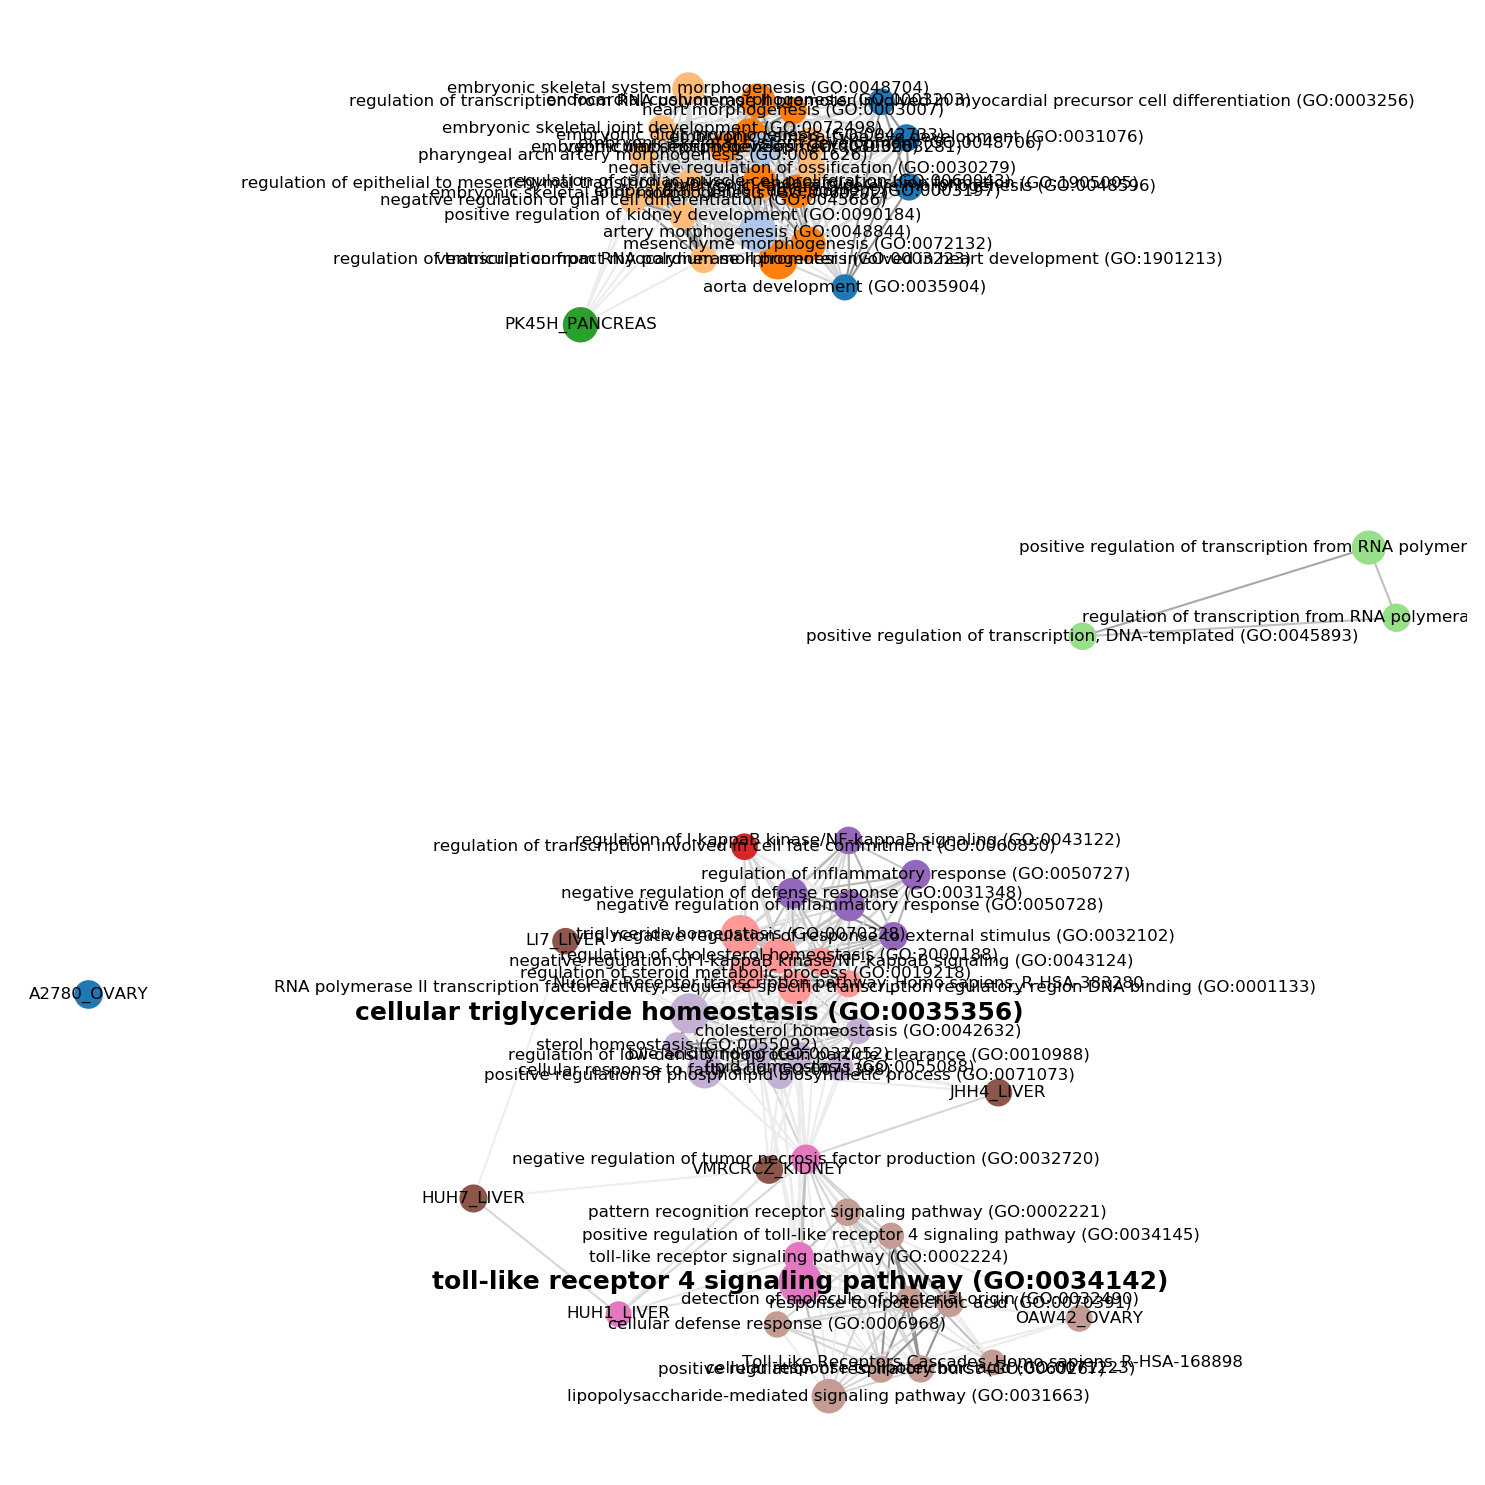

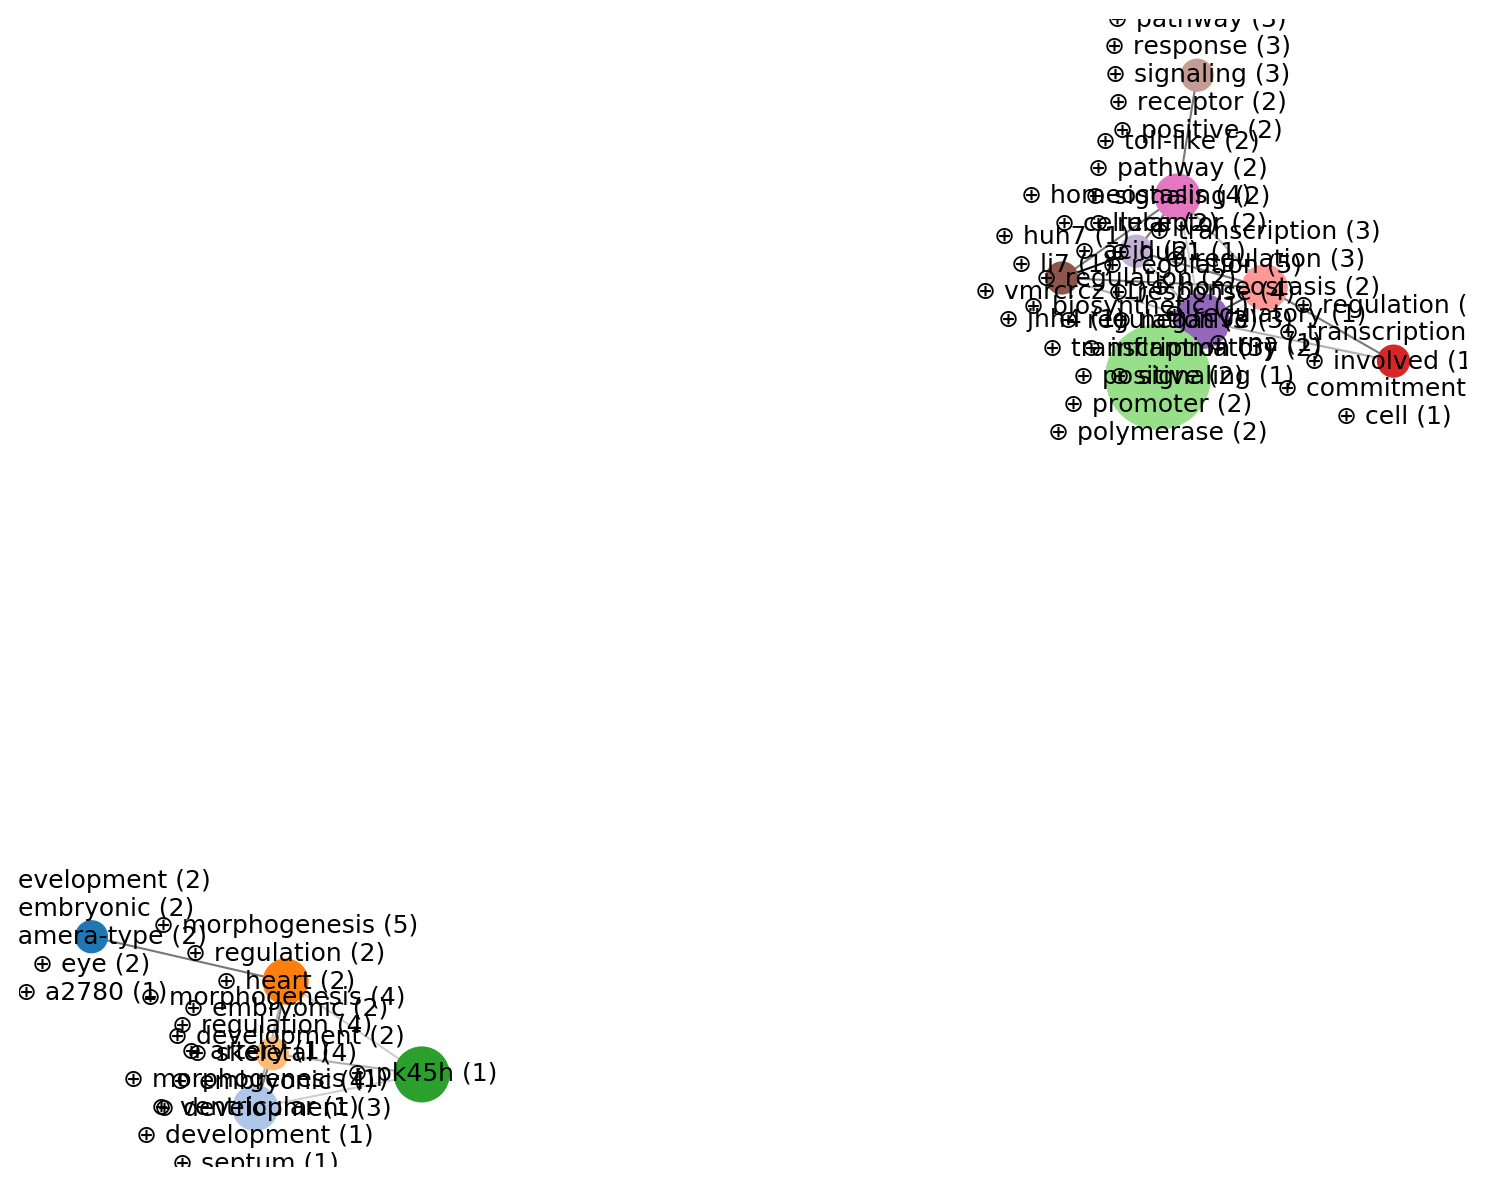

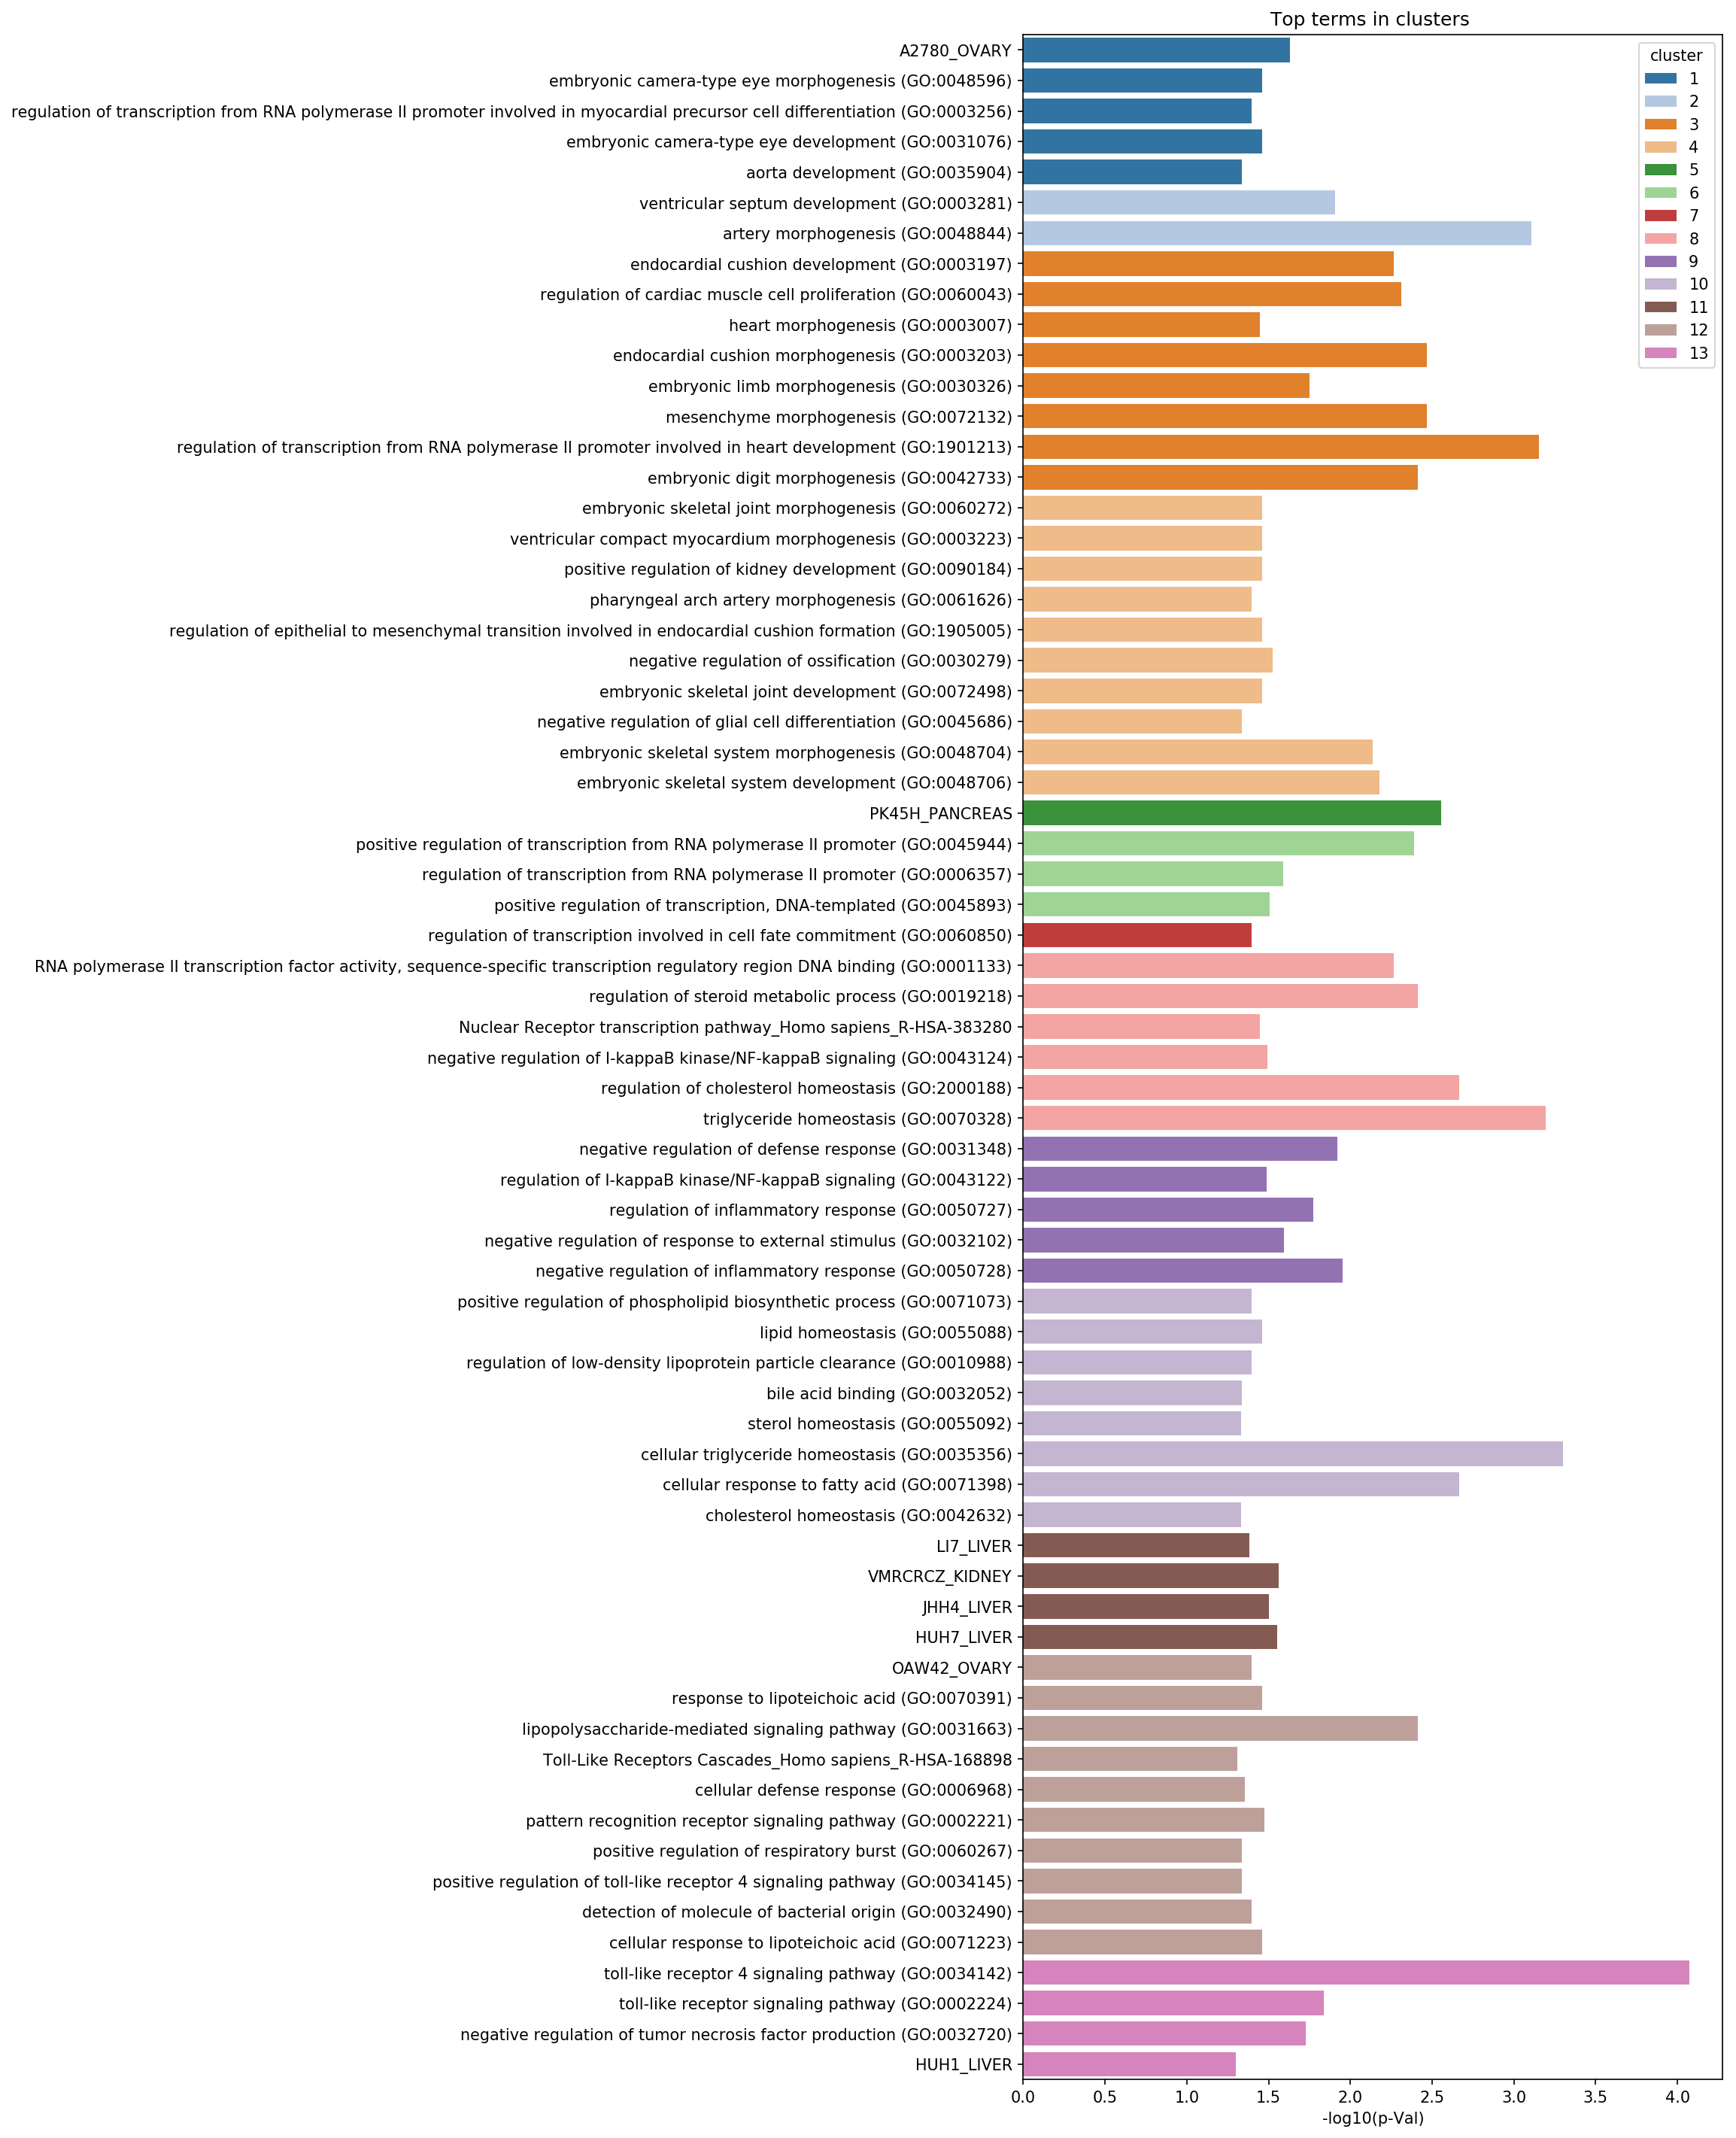

In [51]:
# Clusters and barplot

cluser_enrich(enr,FIN_dn_genes, pval=0.05, top_clusters=14, spring=10)

## Calculate independent distance on selected gene sets (terms)

In [25]:
# Calculate independent distance on selected gene sets (terms)
#enr_c = erl.cluster_jacc(enr_c)


## Double clustering: close terms in both categories

In [26]:
#enr_grp = enr_c.groupby(by=['cluster','cluster_jacc'],axis=0)

# Fucntion takes double cluster and return common genes  

# def get_cluster(cl, enr_grp):
#     enr_clust = enr_a.loc[enr_grp.groups[cl]]
#     gn_clust = set(enr_clust.iloc[0]['genes'])
#     for i in range(len(enr_clust)):
#         gn_clust = gn_clust & set(enr_clust.iloc[i]['genes'])
    
#     return gn_clust

In [27]:
# Print clustes and common genes 


# Terms in cluster
# for k in enr_grp.groups.keys():
#     print(k)
#     for i in list(enr_grp.groups[k]):
#         print('\t',i)

#'num_terms :',len(list(enr_grp.groups[k]))


In [28]:
# Genes common in clusters 
# for k in enr_grp.groups.keys():
#     print(k, get_cluster(k, enr_grp))

In [29]:
# Fucntion takes double cluster and return common genes in terms  

# def get_cluster_terms(cl, enr_grp):
#     enr_clust = enr_a.loc[enr_grp.groups[cl]]
#     gn_clust = set(enr_clust.iloc[0]['term_genes'])
#     for i in range(len(enr_clust)):
#         gn_clust = gn_clust & set(enr_clust.iloc[i]['term_genes'])
    
#     return gn_clust

In [30]:
#tm = enr_a.loc[enr_grp.groups[(7,4)]]

# Story TWO: Active in TLX3 only enhancers with mutation and inactive genes 

![title](im/Story2RAG.png)

## Intersect mutation in TLX3 with active enhancers from privious analysis

In [31]:
## Up enhancers with up genes
# up_enh_up_genes -- list of enhancers
# --| enh_up_up= enh_df[enh_df['name'].isin(up_enh_up_genes)]
# --| enh_up_up_bd = pb.BedTool.from_dataframe(enh_up_up)

# enh_up_up_bd  --- bed file of enhancers
print('Up enhancers of down-regulated genes  = ',len(enh_up_dn_bd))


# tlx_gn -- variants in TLX3


Up enhancers of down-regulated genes  =  4968


In [32]:
# Variant inside active enhancers

enh_mut_tlx = emm.bed_variants(tlx_gn,enh_up_dn_bd)
print('Variants from TLX3 WGS in active enhacers = ', len(enh_mut_tlx))

Variants from TLX3 WGS in active enhacers =  3524


In [33]:
# Save only if new analysis done
enh_mut_tlx.saveas(join(WGS,'Ehn_RAG_Active_TLX3_mut.vcf'))

<BedTool(/home/sergio/Res_CIML/TLX3_project/data/tracks/WGS-WES/Germline/Ehn_RAG_Active_TLX3_mut.vcf)>

In [34]:
# Load table
import allel
enh_mut_tlx_tb = allel.vcf_to_dataframe(join(WGS,'Ehn_RAG_Active_TLX3_mut.vcf'),fields='*', numbers={'ALT': 4}, transformers=allel.ANNTransformer())

In [35]:
enh_mut_tlx_tb_fltr = enh_mut_tlx_tb[enh_mut_tlx_tb['FILTER_PASS']==True]

In [36]:
print('Variants from TLX3 WGS in active enhacers = ', len(enh_mut_tlx_tb))
print('Variants from TLX3 WGS in active enhacers PASS filter = ', len(enh_mut_tlx_tb_fltr))

Variants from TLX3 WGS in active enhacers =  3524
Variants from TLX3 WGS in active enhacers PASS filter =  2678


In [37]:
#enh_mut_tlx_tb[['FILTER_map','FILTER_PASS','FILTER_mrd20','FILTER_LowQual','FILTER_mrd10','FILTER_mrd30']].head(40)
#tnm = plt.hist(enh_mut_tlx_tb['REF'].apply(len), bins=40)
#tnm = plt.hist(enh_mut_tlx_tb['ALT_1'].apply(len), bins=40)

## Motifs around mutations in active enhancers

In [38]:
# Motifs models DB
db_f = '/home/sergio/tools/deepbind/db/db.tsv'

db = pd.read_csv(db_f, sep='\t',comment="#", index_col=0)
db = db[db['Labels'].isnull()]
db.drop(columns=['Class','Experiment Details','Model','Cite','Labels','Path','Comment'], inplace=True)

# Select on TFs in mouse
db_tf = db[db['Type']=='TF']
db_tf = db_tf[db_tf['Species']=='Mus musculus']


In [39]:
# Reference genome fasta
from pyfaidx import Fasta
fn = '/home/sergio/media/NAS4/PFlab/TLX3_project/WES-seq/references/mouse_mm9_reference_genome.fa'
fa = Fasta(fn)

In [40]:
# mut_tb = enh_mut_tlx_tb[['CHROM', 'POS', 'REF', 'ALT_1','is_snp']]
# mut_tb = mut_tb.assign(REF_Prot="",
#                        REF_score_ref = np.nan,
#                        REF_score_alt = np.nan,
#                        REF_model = "",
#                        ALT_Prot="", 
#                        ALT_score_ref = np.nan,
#                        ALT_score_alt = np.nan,
#                        ALT_model = "")
# cols = ['CHROM', 'POS', 'REF', 'ALT_1', 'is_snp', 
#         'REF_Prot', 'REF_model', 'REF_score_ref','REF_score_alt', 
#         'ALT_Prot', 'ALT_model', 'ALT_score_ref', 'ALT_score_alt']

# mut_tb = mut_tb[cols]

# pad = 10

# # Cycling
# for i in range(len(mut_tb)):
#     var= mut_tb.loc[i]

#     ln = len(var['REF'])
#     rg = fa[var['CHROM']][int(var['POS'])-pad:int(var['POS'])+ln+pad]

#     pos = var['POS'] - rg.start
#     ref = var['REF'].upper()
#     alt = var['ALT_1'].upper()

#     fs = rg.seq.upper()
#     fm = emm.mut(fs,pos,ref,alt)

#     ### Find best model
#     dv = db_tf.copy()

#     dv['score_ref'] = list(emm.deepbind_list(list(dv.index),fs)['score'])
#     dv['score_alt'] = list(emm.deepbind_list(list(dv.index),fm)['score'])
#     dv_r = dv.sort_values('score_ref',axis=0, ascending=False)
#     dv_a = dv.sort_values('score_alt',axis=0, ascending=False)



#     mut_tb['REF_Prot'].loc[i] = dv_r.iloc[0]['Protein']
#     mut_tb['REF_score_ref'].loc[i] = dv_r.iloc[0]['score_ref']
#     mut_tb['REF_score_alt'].loc[i] = dv_r.iloc[0]['score_alt'] 
#     mut_tb['REF_model'].loc[i] = dv_r.index[0] 


#     mut_tb['ALT_Prot'].loc[i] = dv_a.iloc[0]['Protein'] 
#     mut_tb['ALT_score_ref'].loc[i] = dv_a.iloc[0]['score_ref']
#     mut_tb['ALT_score_alt'].loc[i] = dv_a.iloc[0]['score_alt']
#     mut_tb['ALT_model'].loc[i] = dv_a.index[0] 


# mut_tb.to_csv(join(WGS,'Variants_Enhancers_RAG_Motifs_scores.csv'))

In [41]:
mut_tb = pd.DataFrame.from_csv(join(WGS,'Variants_Enhancers_RAG_Motifs_scores.csv'))


### Select motifs with high score and ones which change TFBS
#### Sort selected motifs by score changes caused by mutation

In [42]:
mut_tb_fltr = mut_tb[(mut_tb['REF_Prot'] != mut_tb['ALT_Prot']) & (mut_tb['REF_score_ref']>2)]
mut_tb_fltr['REF_score_diff'] = mut_tb_fltr['REF_score_ref'] - mut_tb_fltr['REF_score_alt']

mut_tb_fltr_srt = mut_tb_fltr.sort_values('REF_score_diff',axis=0, ascending=False)

In [43]:
mut_tb_fltr_srt.head(20)

CHROM        POS         REF ALT_1  is_snp REF_Prot   REF_model  \
1344  chr15   58834538           T     C    True     Rfx7  D00072.001   
3476   chr9  103373665           A     C    True     Sox6  D00039.001   
1780  chr17   31870432          CA     C   False     Tbx3  D00018.001   
1106  chr13   64511939   TCCCCCCCC     T   False   Znf740  D00083.001   
250    chr1   36628940           C   CTG   False   Znf740  D00083.001   
1781  chr17   31870434           C     T    True     Tbx3  D00018.001   
2533   chr5  100486618  TCCCCCCCCC     T   False   Znf740  D00083.001   
1681  chr17   30268772           T     G    True     Sox6  D00039.001   
2661   chr6  115711407           T     G    True     Sox6  D00039.001   
1901  chr17   34775897           A     T    True     Sox6  D00039.001   
2097  chr19   16391112           C     A    True     Sox6  D00039.001   
1104  chr13   64511021           T     C    True    Foxc2  D00061.001   
2937   chr6  135224393           C     G    True    Foxc2  D00061.001   
969   chr12  114176823           G     T    True   Znf740  D00083.001   
1370  chr15   60960522           T     G    True     Sox6  D00039.001   
819   chr12   71335657           G     T    True     Sox6  D00039.001   
771   chr11  116472263           G     T    True     Sox6  D00039.001   
2720   chr6  121002420           C   CCT   False      Sp1  D00017.001   
2759   chr6  121018576           C     G    True    Nr5a2  D00069.001   
3424   chr9   77344019           G     A    True     Sox6  D00039.001   

      REF_score_ref  REF_score_alt ALT_Prot   ALT_model  ALT_score_ref  \
1344      33.357822       1.262218     Klf9  D00026.001       3.404741   
3476      29.214870       1.121617    Foxc2  D00061.001       4.474813   
1780      19.754713       0.238770     Gbx1  D00414.003       1.168410   
1106      19.278561      -0.074207     Egr3  D00058.001       5.968520   
250       19.221281       0.575953   Zfp202  D00047.001       9.874022   
1781      18.376518      -0.001189    Nr2f6  D00030.004       0.631192   
2533      21.936911       3.737957     Egr3  D00058.001       6.223981   
1681      18.329845       0.294959   Rhox11  D00620.003       0.704804   
2661      17.896835       0.255039    Foxk1  D00402.001       0.022918   
1901      19.621002       3.179841    Foxc2  D00061.001       2.567387   
2097      17.045650       0.854596    Foxc2  D00061.001       3.449110   
1104      15.535240       1.354064   Ahctf1  D00053.001       2.572171   
2937      15.837371       1.728355    Foxg1  D00062.001      14.146044   
969       19.392925       5.613884   Zfp263  D00048.001      18.762094   
1370      12.645449       0.477769     Rfx7  D00072.001       2.251810   
819       12.377302       0.460536   Dmrtc2  D00057.001       1.860613   
771       12.464957       0.655531    Foxc2  D00061.001       5.547304   
2720      13.755694       1.988670     Egr3  D00058.001       6.908875   
2759      10.727611       0.142102     Tbx2  D00041.001      -0.190868   
3424      10.715470       0.406012     Oct1  D00032.001       1.309024   

      ALT_score_alt  REF_score_diff  
1344       3.979531       32.095604  
3476       3.646667       28.093253  
1780       1.985958       19.515943  
1106       2.003879       19.352768  
250        4.277870       18.645328  
1781       0.808165       18.377707  
2533       4.705463       18.198954  
1681       1.149191       18.034886  
2661       0.664287       17.641796  
1901       3.997139       16.441161  
2097       4.421881       16.191054  
1104       1.916417       14.181176  
2937       3.298738       14.109016  
969       14.236339       13.779041  
1370       0.881329       12.167680  
819        2.447182       11.916766  
771        4.020530       11.809426  
2720       5.690184       11.767024  
2759       1.268350       10.585509  
3424       1.362404       10.309458

## Find enhacers with TFS changes and associated genes

In [44]:
# Back to bed and enhancers list
mut_bd = mut_tb_fltr_srt[mut_tb_fltr_srt['REF_score_diff']>1][['CHROM','POS','REF','REF_Prot']]


mut_bd['POS_end'] = mut_bd['POS']+mut_bd['REF'].apply(len)
mut_bd = mut_bd[['CHROM','POS','POS_end', 'REF_Prot']]

mut_tf = pb.BedTool.from_dataframe(mut_bd).sort()
mut_tf_enh = enh.intersect(mut_tf,wb=True).to_dataframe()
mut_tf_enh.drop(columns=['score','strand','thickStart'], inplace=True)
mut_tf_enh.rename(columns={'thickEnd':'protein'}, inplace=True)

genes_mut_tf_enh = emm.gene_enh(list(mut_tf_enh['name']),enh2gn)

In [45]:
print('Genes with enhacers with TFBS cahnges = ', len(genes_mut_tf_enh)) 

Genes with enhacers with TFBS cahnges =  405


In [46]:
print('Genes with enhacers with TFBS cahnges:\n', genes_mut_tf_enh) 

Genes with enhacers with TFBS cahnges:
 ['Csrp1', 'Creg2', 'A830018L16Rik', 'C630050I24Rik', 'Cep72', 'Ttpa', 'Tspan9', 'Oxr1', 'Gm17541', 'Als2cl', 'Thbs4', 'Efhc1', 'Nsun7', 'Prss30', 'Ndufa12', 'Epas1', 'Pgpep1l', 'Dbx1', 'Fgd6', 'Nrg2', 'Afap1', 'Chsy1', 'Abra', 'Cdv3', 'Spon1', 'Prex1', 'Isoc1', 'Ppp1r13b', 'Bhmt', 'Tmem204', 'Art2b', 'A1bg', 'Ucp3', 'Wdr95', 'Slco3a1', 'Arfgef1', 'Ccnjl', 'Cep170b', 'Gpr110', 'Gata6', 'Cxcl10', 'Mad1l1', 'H2-Aa', 'Themis3', 'Vipr2', 'Yy1', 'Evl', 'Ighg2c', 'Myl1', 'Gga1', 'Ift122', '2300002M23Rik', 'Ptprn2', 'Fer1l6', 'Ablim2', 'Rhobtb3', 'H2-Q4', 'B3gnt6', 'Pdgfb', 'Tmem247', 'Pcif1', 'Zfp608', 'Mtss1', 'Hk3', 'Rad51b', 'Tmcc3', 'Mansc1', 'Arsb', 'Ccdc68', 'Asph', 'Ccdc85a', 'Ntn4', 'Rpl36-ps3', 'Itpk1', 'Mpp7', 'Hsf2bp', 'Arid5b', 'P2ry2', 'Il18bp', 'P2ry6', 'Supt3', 'Rfx8', 'Mettl14', 'Tmem65', 'Gna14', 'Gypc', 'Prex2', 'F2rl2', 'Ptprm', 'Clec2g', 'Frmd4b', 'Zcchc12', 'Narg2', 'Lgi2', 'Fam43a', 'Foxn4', 'Mctp1', 'Ano6', 'Anp32a', 'Dmgdh', 'Jmy

### Genes enrichments

In [47]:
genes_mut_tf_enh = [x.upper() for x in genes_mut_tf_enh]

enr_genes_mut_tf_enh = erl.enrich_gs(genes_mut_tf_enh,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 2006
GO_Cellular_Component_2018 182
GO_Molecular_Function_2018 429
KEGG_2016 217
Reactome_2016 606
Cancer_Cell_Line_Encyclopedia 874
NCI-60_Cancer_Cell_Lines 92


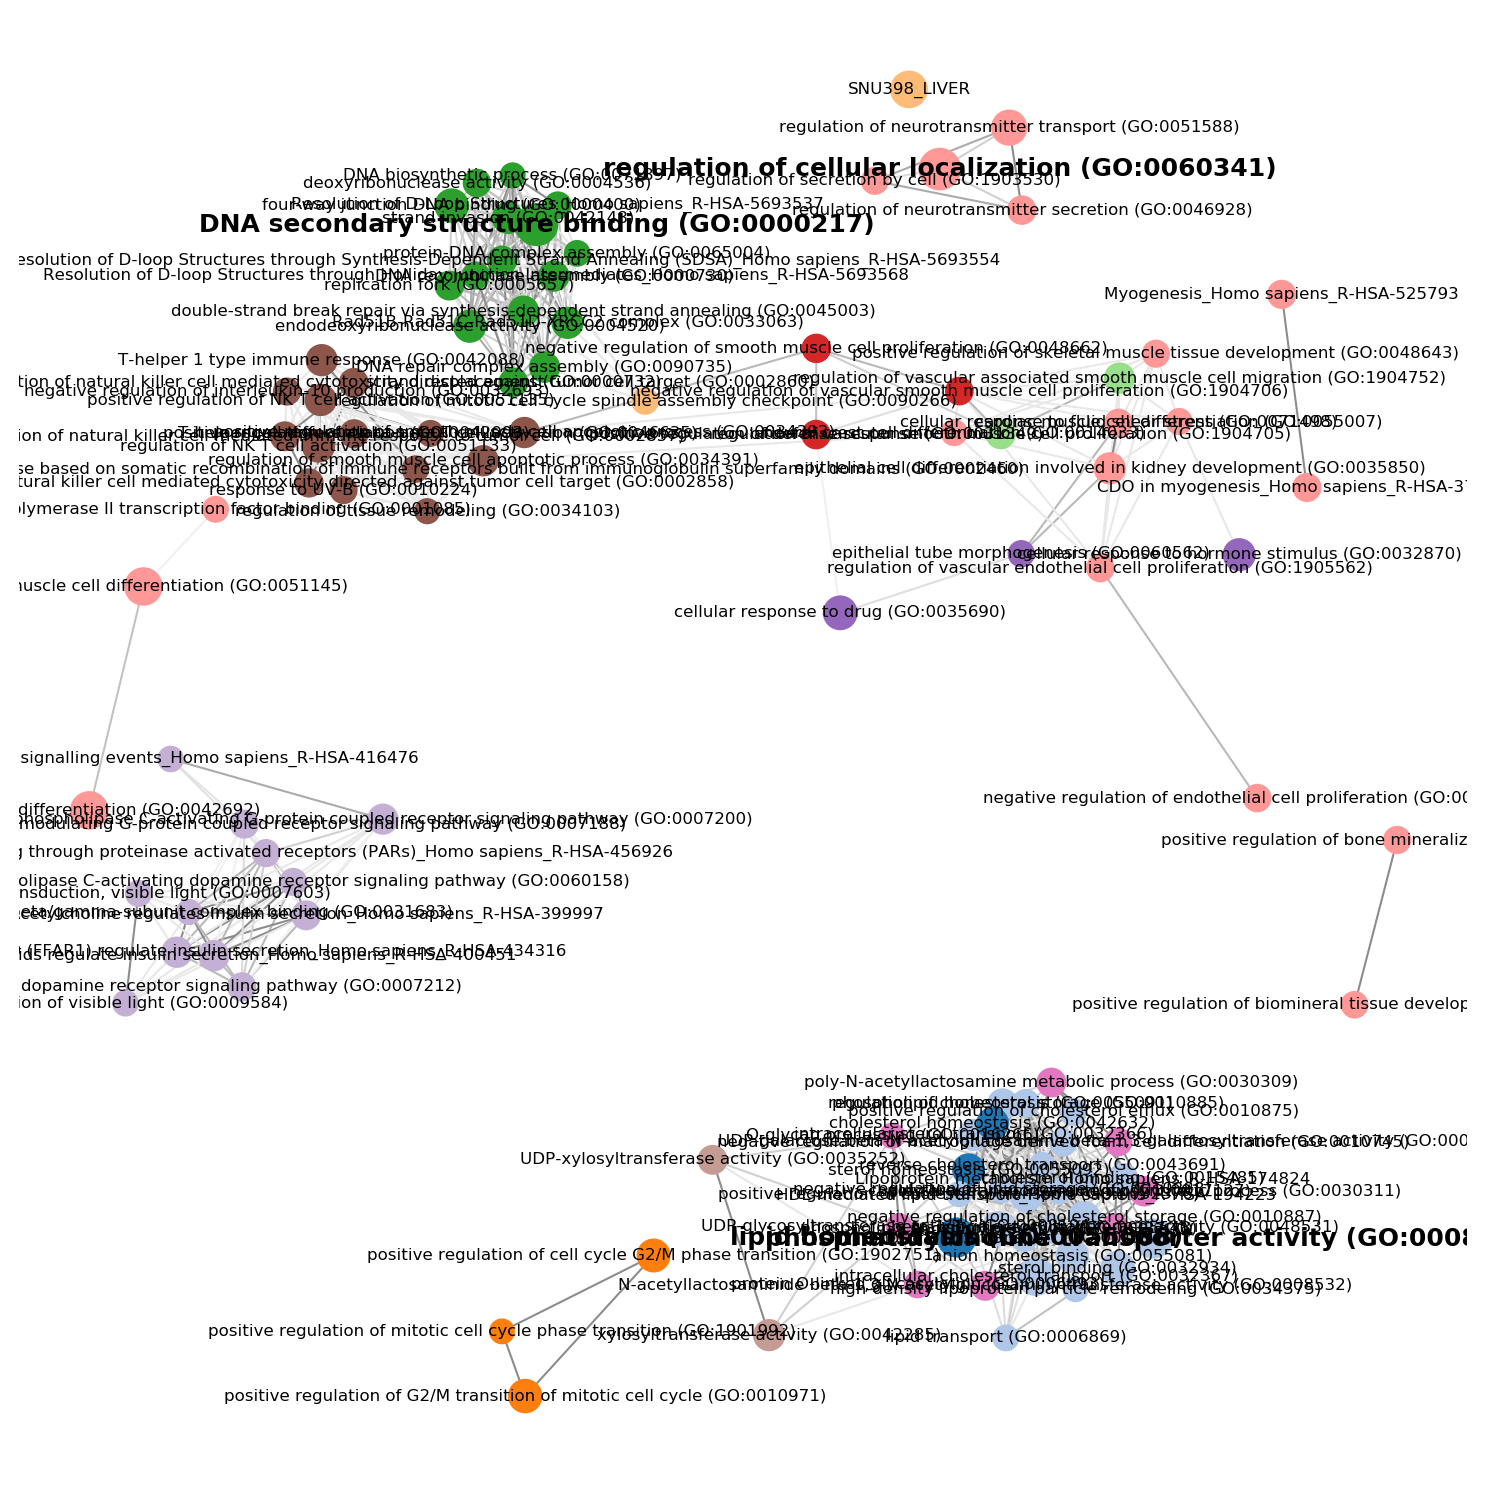

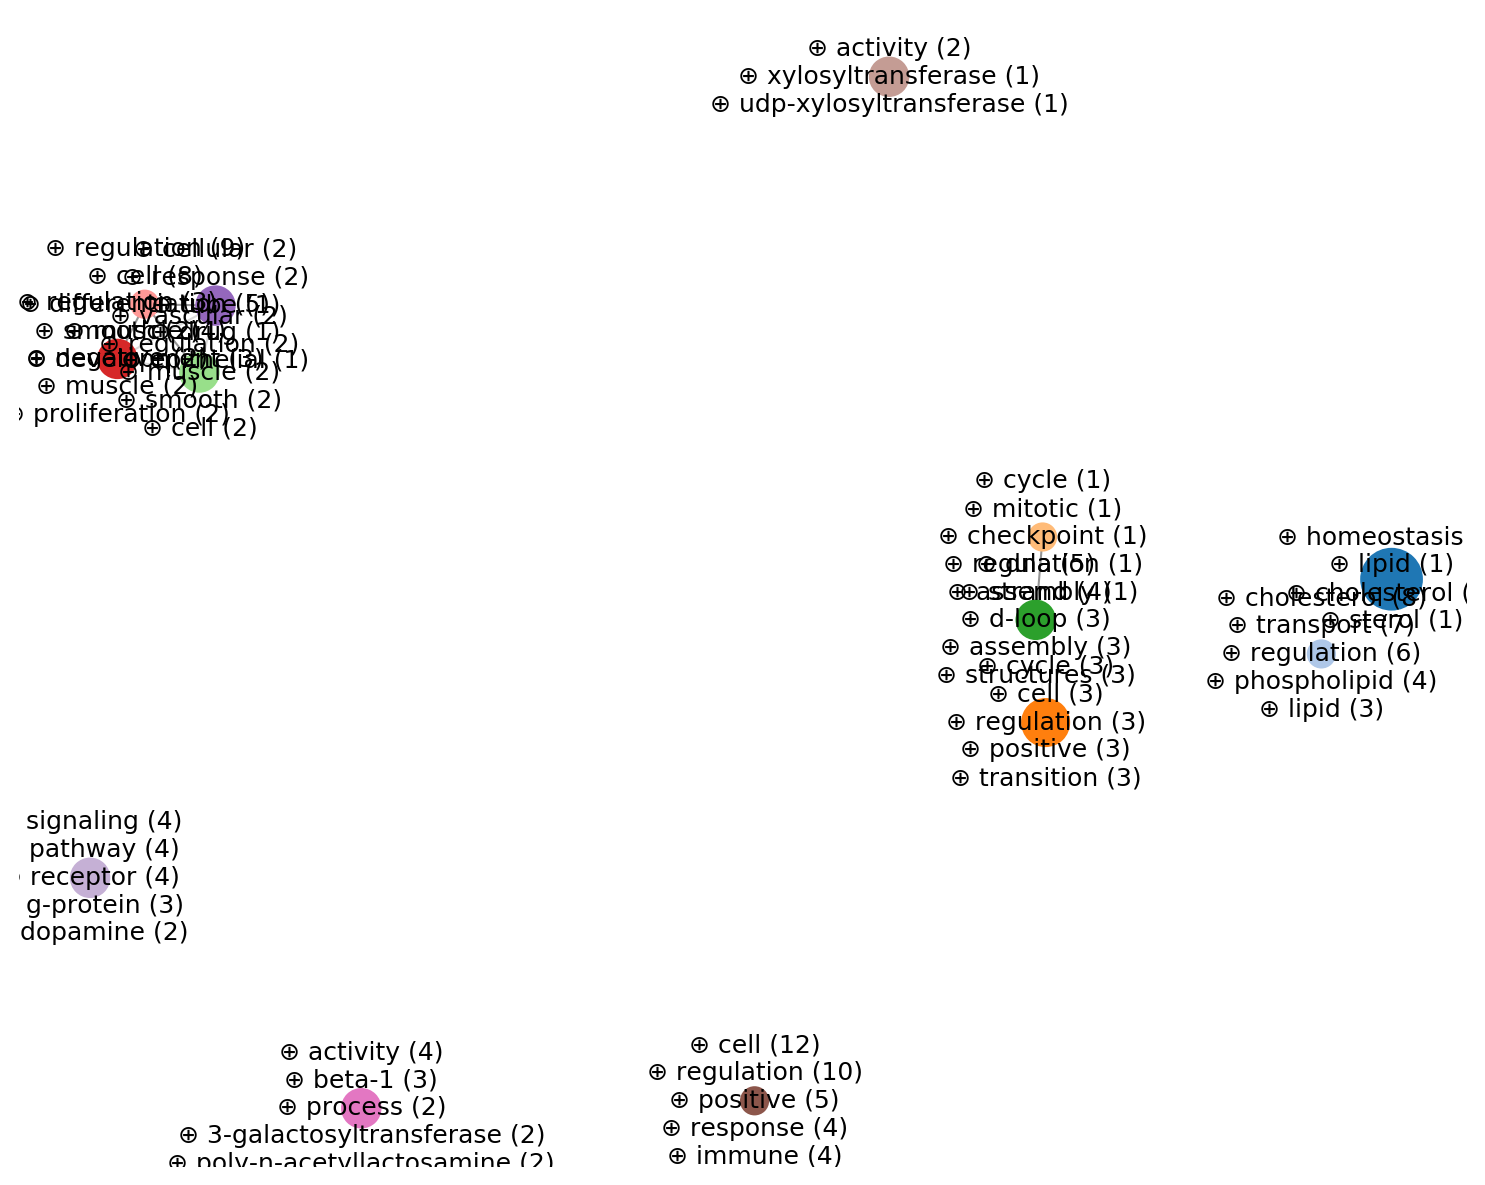

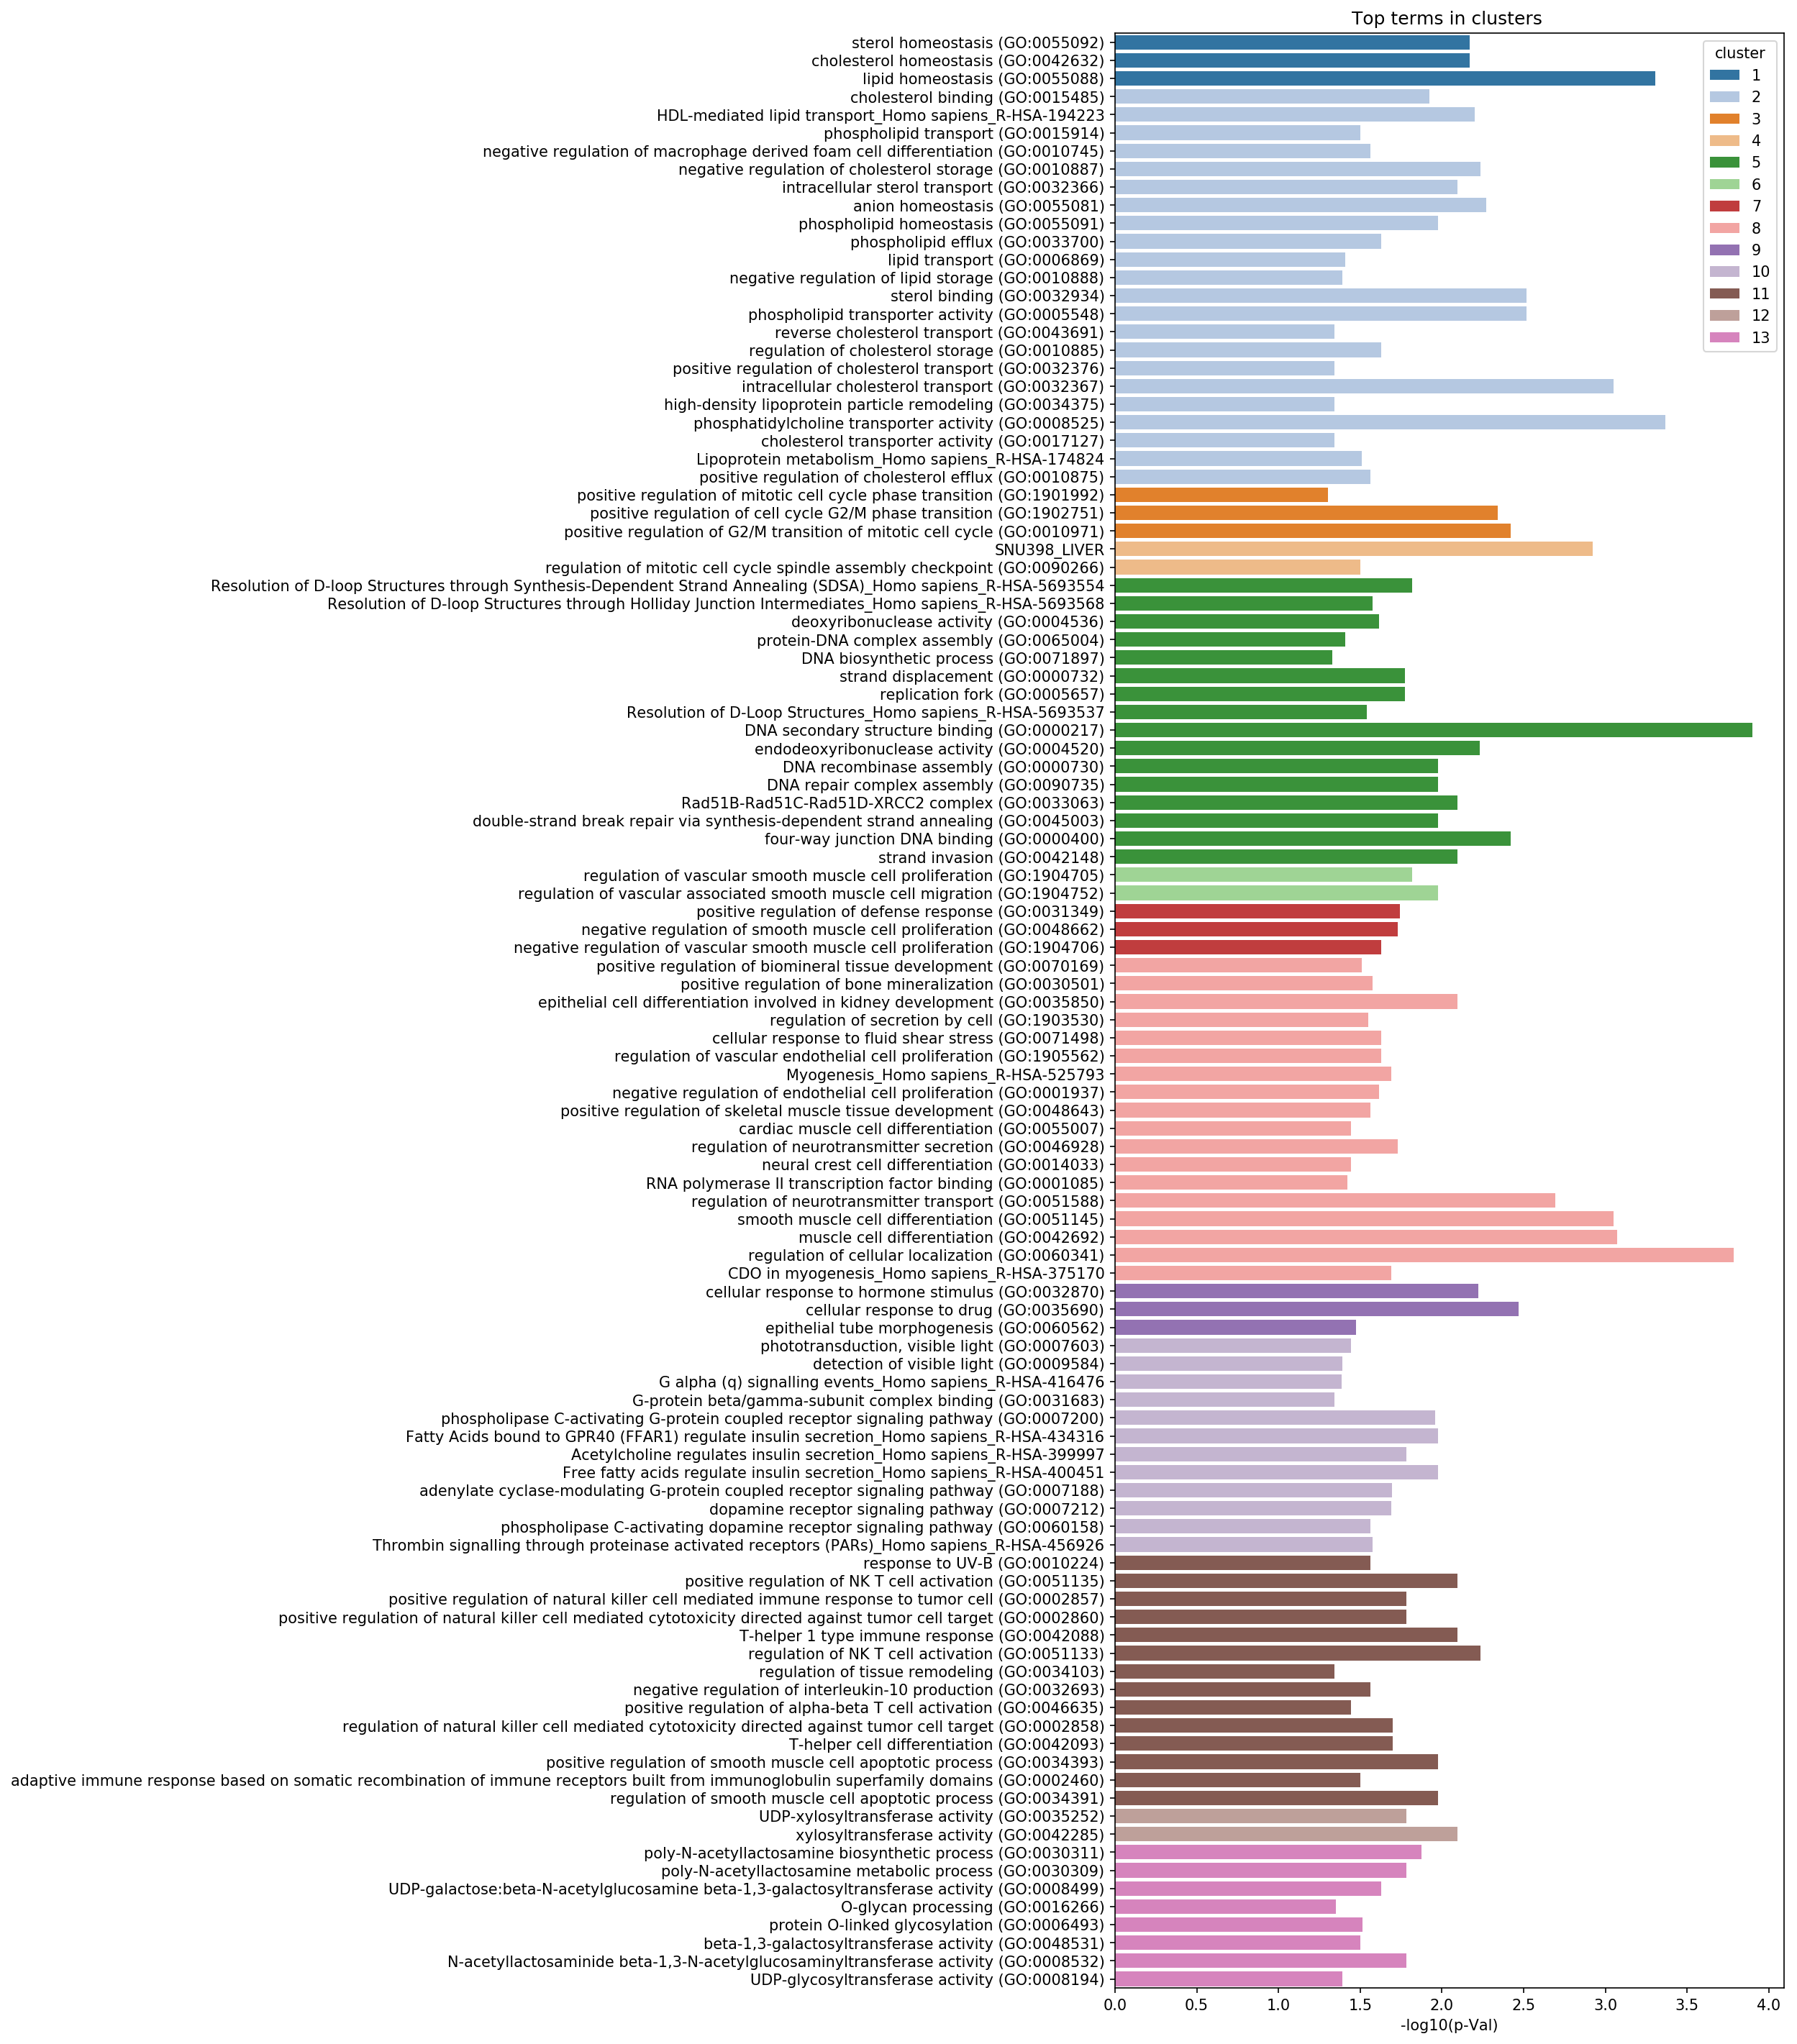

In [52]:
cluser_enrich(enr_genes_mut_tf_enh,genes_mut_tf_enh,pval=0.05, top_clusters=14, spring=10)